## Rankings clasificación

**Adrián Arnaiz Rodríguez**

Realizaremos rankings de:
1. Experimentos con clasificadores con parámetros por defecto.

2. **TODO** Experimentos con clasificadores con búsqueda de parámetros y preprocesado (SKBest, VT...)
 * Definir pipelines (Pre+Clf)
 * Definir qué parámetros del pipeline serán optimizados.
 * Optimizar y sacar métricas con optimizado



**Clasificadores a utilizar-optimizar**
- Knn
- Tree
- Bayes
- SVM
- RandomF
- Ada
- GBC
- MLP

**Como optimizar clfs y pretratamiento de ccas**
- GS de parametros

# 1. Experimentos con sin preprocesado ni búsqueda de parámetros

In [1]:
experiments = True

algoritmos = [
    {
        "ID_ALG":"KNN8",
        "ALGO": "sklearn.neighbors.KNeighborsClassifier",
        "PARAMS":{
            "n_neighbors":8,
            "metric":"euclidean"
        }
    },
    {
        "ID_ALG":"Tree",
        "ALGO": "sklearn.tree.DecisionTreeClassifier",
        "PARAMS":{  # Parámetros por defecto       
        }
    },
    {
        "ID_ALG":"MLP10",
        "ALGO": "sklearn.neural_network.MLPClassifier",
        "PARAMS":{ "hidden_layer_sizes":10,
                  'max_iter':700,
        },
    },
    {
        "ID_ALG":"RF",
        "ALGO": "sklearn.ensemble.RandomForestClassifier",
        "PARAMS":{
        }
    },
    {
        "ID_ALG":"SVM",
        "ALGO": "sklearn.svm.SVC",
        "PARAMS":{
        }
    },
    {
        "ID_ALG":"Bayes",
        "ALGO": "sklearn.naive_bayes.GaussianNB",
        "PARAMS":{  # Parámetros por defecto       
        }
    },
    {
        "ID_ALG":"GBC",
        "ALGO": "sklearn.ensemble.GradientBoostingClassifier",
        "PARAMS":{ 
        }
    },
    {
        "ID_ALG":"Ada",
        "ALGO": "sklearn.ensemble.AdaBoostClassifier",
        "PARAMS":{ 
        }
    },
]

In [2]:
import bunch_loader as loader
import pandas as pd
import numpy as np

In [3]:
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import importlib
import warnings
warnings.filterwarnings('ignore')

def run_experiments(modulo, modelos, n_cv=10, verbose=False):
    aucs = dict()
    accuracys = dict()
    
    datasets_loaders = [d for d in dir(modulo) if d.startswith('load')]
    for dtst in datasets_loaders:
        aucs[dtst[5:]]={}
        accuracys[dtst[5:]]={}
        data_bunch = getattr(modulo, dtst)()
        X = data_bunch['data']
        y = data_bunch['target']
        
        # Para utilizar los mismos folds en todos los clf, inicializamos los folds
        skf = StratifiedKFold(n_splits=10)
        cv_generator = list(skf.split(X, y))
        
        if verbose: print('---------\n',dtst)
        
        
        for clf in modelos:
            #Cargamos el modelo de manera dinámica
            metodo = clf['ALGO']
            puntos = [pos for pos, char in enumerate(metodo) if char == "."]
            libreria = importlib.import_module(metodo[:puntos[-1]]) #nombre del modulo
            clase = getattr(libreria, metodo[puntos[-1]+1:]) #nombre de la clase
            
            #Creamos y ejecutamos el pipeline de clasificacion
            pip = Pipeline([('norm', MinMaxScaler()),('clf', clase(**clf["PARAMS"]))])
            cv_res = cross_validate(pip,
                                    X,y,
                                    #cv=StratifiedKFold(n_splits=n_cv), 
                                    cv = cv_generator,
                                    scoring = {'AUC':'roc_auc', 'ACCURACY':'accuracy'}, 
                                    return_train_score=False)
            
            # Guardamos resultados
            aucs[dtst[5:]][clf['ID_ALG']] = cv_res['test_AUC'].mean()
            accuracys[dtst[5:]][clf['ID_ALG']] = cv_res['test_ACCURACY'].mean()
            
            #cv_res
            if verbose:
                print(metodo)
                print('\tAUC: {:.4f} +- {:.2f}'.format(cv_res['test_AUC'].mean(), cv_res['test_AUC'].std()), end = '||')
                print('ACCURACY: {:.4f} +- {:.2f}'.format(cv_res['test_ACCURACY'].mean(), cv_res['test_ACCURACY'].std()))
        
    return aucs, accuracys


In [4]:
if experiments:
    auc_res, accuracys_res = run_experiments(loader, algoritmos, 10, verbose=False)
    clf_bin_auc_default = pd.DataFrame(auc_res).transpose()
    clf_bin_auc_default.to_csv('resultados/bin_clf_auc_default.csv', header=True, index_label='Dataset')

In [5]:
clf_bin_auc_default = pd.read_csv('resultados/bin_clf_auc_default.csv')
clf_bin_auc_default

,Dataset,KNN8,Tree,MLP10,RF,SVM,Bayes,GBC,Ada
0,art_rt,0.666000,0.580000,0.692000,0.664000,0.760000,0.694000,0.752000,0.784000
1,art_w_atleta,0.646000,0.570000,0.744000,0.542000,0.684000,0.638000,0.676000,0.732000
2,art_w_braso,0.590000,0.540000,0.572000,0.508000,0.676000,0.692000,0.636000,0.544000
3,art_w_campana,0.638000,0.520000,0.652000,0.638000,0.700000,0.678000,0.668000,0.708000
4,art_w_gato,0.706000,0.550000,0.636000,0.626000,0.676000,0.672000,0.684000,0.632000
5,art_w_petaka,0.594000,0.570000,0.668000,0.674000,0.708000,0.716000,0.724000,0.616000
6,fon_rt,0.522000,0.540000,0.516000,0.616000,0.444000,0.588000,0.692000,0.840000
7,fon_v_A,0.611333,0.590000,0.691556,0.672889,0.685778,0.681778,0.688444,0.652000
8,fon_v_E,0.620444,0.620000,0.736444,0.689111,0.703111,0.715778,0.676000,0.651111
9,fon_v_I,0.640889,0.583333,0.720000,0.651333,0.676889,0.668000,0.685778,0.625333


Maximos por clasificador:

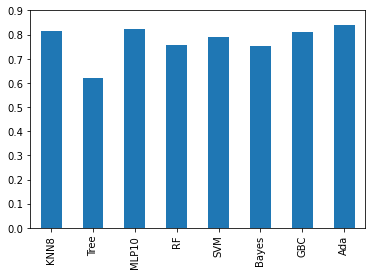

In [6]:
clf_bin_auc_default.drop('Dataset', axis=1).max(axis=0).plot(kind='bar', ylim=[0,0.9])

Medias por clasificador

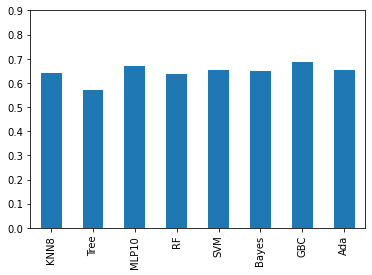

In [7]:
clf_bin_auc_default.drop('Dataset', axis=1).mean(axis=0).plot(kind='bar', ylim=[0,0.9])

Medias y varianza por dataset

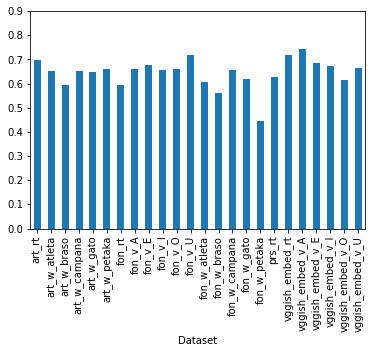

In [8]:
clf_bin_auc_default.set_index('Dataset').mean(axis=1).plot(kind='bar',ylim=[0,0.9])

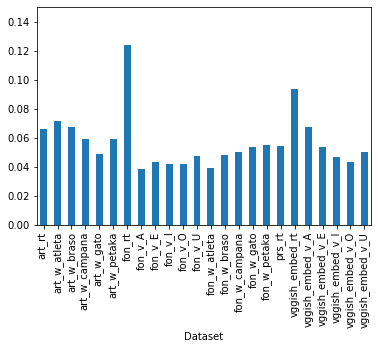

In [9]:
clf_bin_auc_default.set_index('Dataset').std(axis=1).plot(kind='bar',ylim=[0,0.15])

In [10]:
import my_posthoc.post_hoc as ph

In [11]:
df_Hoch, avg_rank = ph.posthoc_Friedman_Davenport_Hochbertest(clf_bin_auc_default) 

### Experimento
# Number of classifiers: 8
# Number of datasets: 24
# Name of classifiers: KNN8, Tree, MLP10, RF, SVM, Bayes, GBC, Ada
# Alpha: 0.05

### Métricas
# Test de Friedman sobre métricas 
	-> p-val: 0.0000

### Rankings
# GBC   ranking medio:  2.667
# MLP10 ranking medio:  3.208
# SVM   ranking medio:  4.125
# Bayes ranking medio:  4.375
# Ada   ranking medio:  4.5
# KNN8  ranking medio:  4.667
# RF    ranking medio:  5.167
# Tree  ranking medio:  7.292
# Test de Ivan-Davenport sobre Rankings [F(10.8370, 7, 161)]               
	-> p-val: 0.0000

### Test Hochberg Comparacion GBC vs all
# Tabla de comparación de Rankings:
                  z      p  alpha/i    sig
GBC vs Tree   6.541  0.000    0.007   True
GBC vs RF     3.536  0.000    0.008   True
GBC vs KNN8   2.828  0.005    0.010   True
GBC vs Ada    2.592  0.010    0.012   True
GBC vs Bayes  2.415  0.016    0.017   True
GBC vs SVM    2.062  0.039    0.025  False
GBC vs MLP10  0.765  0.444    0.050  False


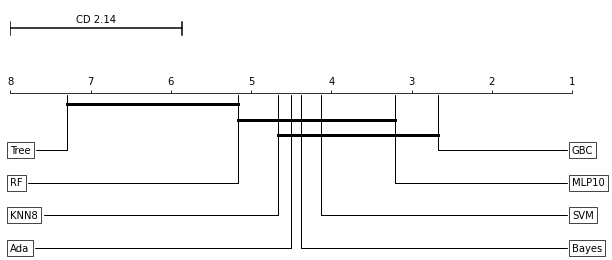

[['Tree', 'RF'],
 ['RF', 'KNN8', 'Ada', 'Bayes', 'SVM', 'MLP10'],
 ['KNN8', 'Ada', 'Bayes', 'SVM', 'MLP10', 'GBC']]

In [12]:
n_dt = clf_bin_auc_default.shape[0]
n_clf = clf_bin_auc_default.shape[1]-1 #Columna de datasets
g = ph.groups_Nemenyi(avg_rank, ph.nemenyi_CD(n_clf, n_dt, alpha=0.05))
ph.plot_nemenyi(avg_rank,ph.nemenyi_CD(n_clf, n_dt, alpha=0.05),g)
g

In [13]:
df_Hoch

,z,p,alpha/i,sig
GBC vs Tree,6.541,0.000,0.007,True
GBC vs RF,3.536,0.000,0.008,True
GBC vs KNN8,2.828,0.005,0.010,True
GBC vs Ada,2.592,0.010,0.012,True
GBC vs Bayes,2.415,0.016,0.017,True
GBC vs SVM,2.062,0.039,0.025,False
GBC vs MLP10,0.765,0.444,0.050,False


***Accuracy***

In [14]:
if experiments:
    clf_bin_accuracy_default = pd.DataFrame(accuracys_res).transpose()
    clf_bin_accuracy_default.to_csv('resultados/bin_clf_accuracy_default.csv', header=True, index_label='Dataset')
clf_bin_accuracy_default = pd.read_csv('resultados/bin_clf_accuracy_default.csv')
clf_bin_accuracy_default

,Dataset,KNN8,Tree,MLP10,RF,SVM,Bayes,GBC,Ada
0,art_rt,0.600000,0.580000,0.610000,0.660000,0.620000,0.660000,0.680000,0.700000
1,art_w_atleta,0.630000,0.570000,0.620000,0.490000,0.560000,0.590000,0.590000,0.630000
2,art_w_braso,0.530000,0.540000,0.510000,0.490000,0.610000,0.640000,0.580000,0.530000
3,art_w_campana,0.580000,0.520000,0.600000,0.600000,0.570000,0.640000,0.620000,0.650000
4,art_w_gato,0.670000,0.550000,0.590000,0.560000,0.630000,0.640000,0.600000,0.600000
5,art_w_petaka,0.570000,0.570000,0.660000,0.600000,0.590000,0.650000,0.690000,0.610000
6,fon_rt,0.550000,0.540000,0.540000,0.590000,0.540000,0.590000,0.620000,0.760000
7,fon_v_A,0.583333,0.590000,0.626667,0.650000,0.640000,0.636667,0.656667,0.646667
8,fon_v_E,0.610000,0.620000,0.663333,0.646667,0.646667,0.646667,0.640000,0.616667
9,fon_v_I,0.603333,0.583333,0.666667,0.640000,0.630000,0.630000,0.630000,0.600000


In [15]:
clf_bin_accuracy_default.mean()

KNN8     0.599941
Tree     0.570112
MLP10    0.621646
RF       0.596917
SVM      0.590014
Bayes    0.608521
GBC      0.636870
Ada      0.619600
dtype: float64

In [16]:
clf_bin_accuracy_default.drop('Dataset', axis=1).max()

KNN8     0.700000
Tree     0.620000
MLP10    0.740000
RF       0.683333
SVM      0.680000
Bayes    0.660000
GBC      0.738571
Ada      0.760000
dtype: float64

Post-hoc

In [17]:
df, avg_r = ph.posthoc_Friedman_Davenport_Hochbertest(clf_bin_accuracy_default) 

### Experimento
# Number of classifiers: 8
# Number of datasets: 24
# Name of classifiers: KNN8, Tree, MLP10, RF, SVM, Bayes, GBC, Ada
# Alpha: 0.05

### Métricas
# Test de Friedman sobre métricas 
	-> p-val: 0.0000

### Rankings
# GBC   ranking medio:  2.417
# MLP10 ranking medio:  3.479
# Ada   ranking medio:  4.042
# Bayes ranking medio:  4.375
# RF    ranking medio:  4.729
# KNN8  ranking medio:  5.104
# SVM   ranking medio:  5.417
# Tree  ranking medio:  6.438
# Test de Ivan-Davenport sobre Rankings [F(7.7837, 7, 161)]               
	-> p-val: 0.0000

### Test Hochberg Comparacion GBC vs all
# Tabla de comparación de Rankings:
                  z      p  alpha/i    sig
GBC vs Tree   5.687  0.000    0.007   True
GBC vs SVM    4.243  0.000    0.008   True
GBC vs KNN8   3.800  0.000    0.010   True
GBC vs RF     3.270  0.001    0.012   True
GBC vs Bayes  2.769  0.006    0.017   True
GBC vs Ada    2.298  0.022    0.025   True
GBC vs MLP10  1.502  0.133    0.050  False


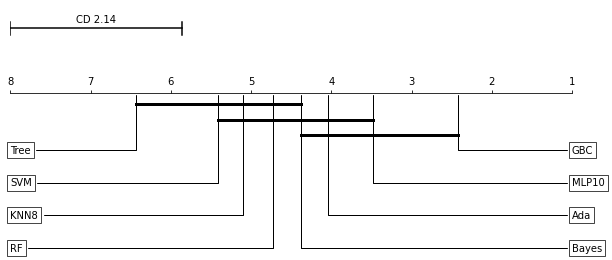

[['Tree', 'SVM', 'KNN8', 'RF', 'Bayes'],
 ['SVM', 'KNN8', 'RF', 'Bayes', 'Ada', 'MLP10'],
 ['Bayes', 'Ada', 'MLP10', 'GBC']]

In [18]:
g = ph.groups_Nemenyi(avg_r, ph.nemenyi_CD(n_clf, n_dt, alpha=0.05))
ph.plot_nemenyi(avg_r,ph.nemenyi_CD(n_clf, n_dt, alpha=0.05),g)
g

# 2. Clasificadores optimizados: TODO

* Grid Search
* Fast Auto ML
* Auto scikitLearn